In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

%matplotlib inline

sns.set_context('talk')

/home/elvynatunggawan/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/elvynatunggawan/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Bayesian A/B Testing

We would like to compare two conversion rates. How good is one option compared to another? First, let's formulate the problem.

In [2]:
def posterior_conversion_rate(converted, bounced, samples=20000):
    N = converted + bounced
    
    with pm.Model() as model:
        ## since conversion rate is continuous, we use pm.Uniform instead of pm.DiscreteUniform
        conversion_rate = pm.Uniform('conversion_rate', 0, 1)
        observation = pm.Binomial('obs', N, conversion_rate, observed=[converted]) # distribution of "success"
        
        trace = pm.sample(samples, step=pm.Metropolis())
        
    return trace['conversion_rate']

$$
X \sim Bin(n, \theta)
$$

Let's take some samples!

In [3]:
a = posterior_conversion_rate(1200, 800)
b = posterior_conversion_rate(1250, 750)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [conversion_rate]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:07<00:00, 10271.81draws/s]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [conversion_rate]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:07<00:00, 10272.13draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [4]:
print("Number of sample in A: {:,.0f}".format(len(a)))
print("Number of sample in B: {:,.0f}".format(len(b)))

print("*) We use 4 chains, each chain contains 2,000 sample.")

Number of sample in A: 80,000
Number of sample in B: 80,000
*) We use 4 chains, each chain contains 2,000 sample.


Now, let's compare the sampling results.

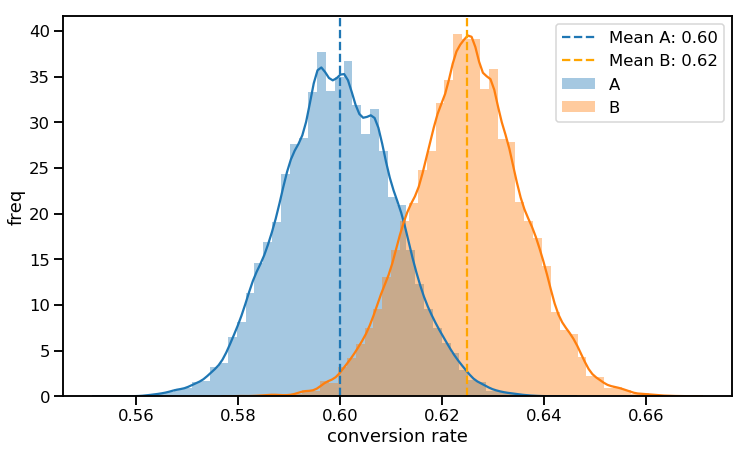

In [5]:
fig, ax = plt.subplots(figsize=(12,7))
sns.distplot(a, label='A', ax=ax)
sns.distplot(b, label='B', ax=ax)

plt.axvline(
    x=1200/(1200+800),
    linestyle='--',
    label='Mean A: {:,.2f}'.format(1200/(1200+800))
)

plt.axvline(
    x=1250/(1250+750),
    linestyle='--',
    color='orange',
    label='Mean B: {:,.2f}'.format(1250/(1250+750)),
)

plt.xlabel('conversion rate')
plt.ylabel('freq')
plt.legend();

You can play with the previous code a bit. Try changing the value of converted or bounced variable. What can you see?

### Reframing the Problem

Let's do it ourselves so we can actually modify the results as we want. In this case, we reframe the problem from $p(a > b)$ to $p(a-b > 0)$.

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [conversion_rate_b]
>Metropolis: [conversion_rate_a]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:09<00:00, 8383.01draws/s] 
The number of effective samples is smaller than 10% for some parameters.


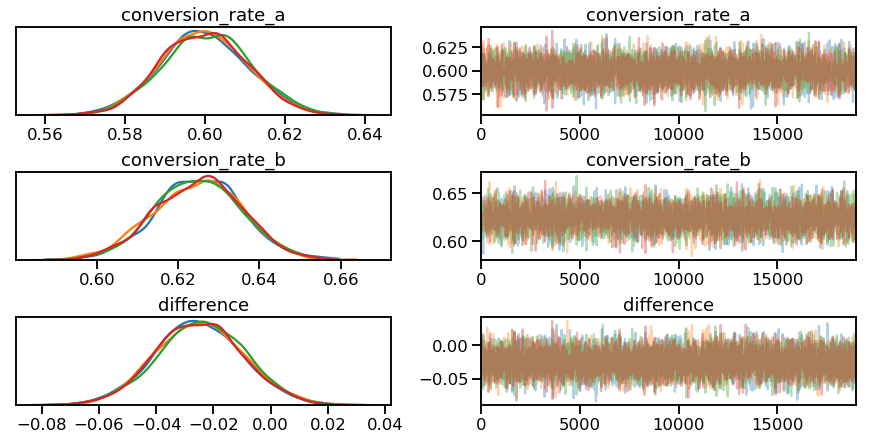

In [6]:
converted_a = 1200
converted_b = 1250
bounced_a = 800
bounced_b = 750
samples = 20000

# Your code here
N_a = converted_a + bounced_a
N_b = converted_b + bounced_b

with pm.Model() as model:
    conversion_rate_a = pm.Uniform('conversion_rate_a', 0, 1) ## you can use Beta too
    observation_a = pm.Binomial('obs_a', N_a, conversion_rate_a, observed=[converted_a])
    
    conversion_rate_b = pm.Uniform('conversion_rate_b', 0, 1) ## you can use Beta too
    observation_b = pm.Binomial('obs_b', N_b, conversion_rate_b, observed=[converted_b])
    
    diff = pm.Deterministic('difference', conversion_rate_a - conversion_rate_b)
    
    trace = pm.sample(samples, step=pm.Metropolis())
    
    ## remove initial sample
    burned_trace = trace[1000:]
    

pm.traceplot(burned_trace);

The previous figure shows you the trace of your sampling method. You can see that the variable name is `burned_trace`. That's because sometimes we might want to throw away some initial samples because it might not be relevant just yet like in the following figure.

<img src="http://www.juergenwiki.de/old_wiki/lib/exe/fetch.php?cache=&media=public:murray_mlss2009talk_mcmc_21.png" width="50%">

Now, using [`pm.plot_posterior`](https://docs.pymc.io/api/plots.html#pymc3.plots.plot_posterior), show the mean of $CTP_A$ and $CTP_B$.

/home/elvynatunggawan/anaconda3/lib/python3.7/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


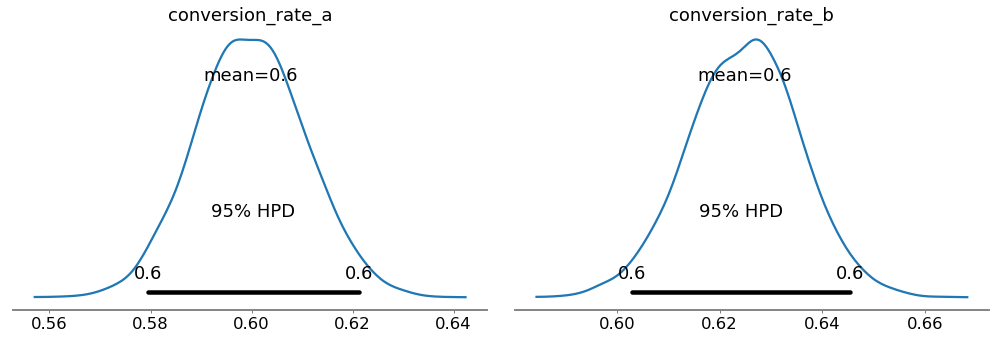

In [7]:
# Your code here
pm.plot_posterior(burned_trace, 
                  varnames=['conversion_rate_a', 'conversion_rate_b'],
                 credible_interval=0.95);

How can you know that option A is better than B for sure? *Or*, instead, we can ask "What is the probability that A beats B?" Again, plot the posterior for this random variable.

In [8]:
# Your code here
(burned_trace['conversion_rate_a'] > burned_trace['conversion_rate_b']).mean()

0.05121052631578947

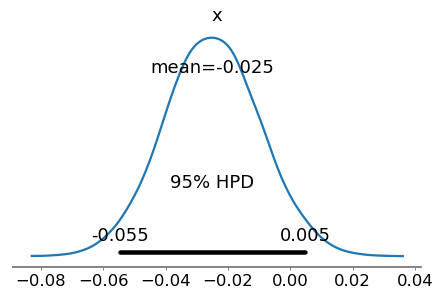

In [9]:
pm.plot_posterior(burned_trace['difference'],
                 round_to=3,
                 credible_interval=0.95);

## Bayesian Search Ranking

First, we will generate a random dataset.

In [10]:
np.random.seed(42)

no_prop = 10
all_ratings = pd.DataFrame()

for i in range(no_prop):
    no_ratings = max(0, int(40*np.random.standard_t(3)+50))
    ratings = pd.DataFrame({
        'property_id': [i] * no_ratings,
        'rating': np.round(10*np.random.beta(7, 2, size=no_ratings), 0)
    })
    all_ratings = pd.concat([
        all_ratings,
        ratings
    ])

Now, let's report the summary statistics. Also, order the properties based on their average rating.

In [16]:
# Your code here
all_ratings.groupby('property_id').agg(['mean','std','count'])

rating                
                 mean       std count
property_id                          
0            7.459459  1.416045    74
1            7.868132  1.343369    91
2            7.416667  1.558055    24
3            7.843137  1.120224    51
4            8.250000  1.238278    16
5            8.034483  1.209568    29
6            7.842105  1.360498   114
7            7.700000  1.341641    20
8            8.111111  0.979148    36
9            7.500000  1.354006    10

We can dig deeper in this problem. Let's take two example properties: prop 3 and 6. Fit a normal distribution to the data and plot them.

In [18]:
from scipy.stats import norm

def draw_norm(df, property_id, ax):
    pass

fig, ax = plt.subplots(figsize=(12,7))
draw_norm(df, 3, ax)
draw_norm(df, 6, ax)
plt.xlim([0,10])
plt.xlabel('review score')
plt.ylabel('density')
plt.legend();

You can see in the previous figure that we don't really take N into account. We should be more certain when we see larger number of samples. What can we do to incorporate this? Use beta distribution!

In [ ]:
from scipy.stats import beta

def draw_beta(df, property_id, ax):
    pass
    
fig, ax = plt.subplots(figsize=(12,7))
draw_beta(df, 3, ax)
draw_beta(df, 6, ax)
plt.xlabel('review score')
plt.ylabel('density')
plt.legend();

Prop 6 which has more ratings is more certain about the true review score! Yay! However, as we are recommending our properties to our customers, and we consider ourselves customer-centric, we should be more cautious, no?

Therefore, we can use the *95% least plausible value*.

> Why is sorting based on this quantity a good idea? By ordering by the 95% least plausible value, we are being the most conservative with what we think is best. [(Davidson-Pilon, 2015)](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter4_TheGreatestTheoremNeverTold/Ch4_LawOfLargeNumbers_PyMC3.ipynb)

### The Exploratory Code

Given what you have already learned from the previous section, formulate the posterior score function.

In [ ]:
def posterior_score(N, sum_of_ratings, samples=20000):
    pass

Next, we will try to visualize 3 sample properties to compare them.

In [ ]:
from tqdm import tqdm_notebook as tqdm

fig, ax = plt.subplots(figsize=(12,7))
for i, row in tqdm(agg_review.sample(3).iterrows(), leave=False):
    true_score = posterior_score(row['count'], row['sum']/10, 5000)
    sns.distplot(true_score, label='Prop {} (N={})'.format(int(row['property_id']), int(row['count'])), ax=ax)
plt.legend();

### The Production-friendly Code

The following code is from the analytical solution, i.e. deriving the posterior distribution and using the normal/Gaussian distribution approximation to the beta distribution.

$$
\frac{a}{a+b} - 1.65 \sqrt{\frac{ab}{(a+b)^2(a+b+1)}}
$$

where

$a = 1 + S$

$b = 1 + N - S$

where $N$ is the number of users who rated, and $S$ is the sum of all the ratings.

In [ ]:
def lower_bound(a, b):
    mean = # your code here
    stdev = # your code here
    return mean, stdev

In [ ]:
agg_review['mle'] = agg_review['mean']
posterior_mean, std_err = # your code here
agg_review['lower'] = # your code here
agg_review['posterior_mean'] = posterior_mean
agg_review['std_err'] = std_err

To make it easier to evaluate more properties, we can plot them like in the following figure. The dots are the posterior mean, which should be similar to your usual average scores. However, we are sorting the properties based on the left-most bars which correspond to the 95% least plausible value from the distribution.

In [ ]:
order = np.argsort(agg_review['lower']).values
fig, ax = plt.subplots(figsize=(12,7))
ax.errorbar(
    agg_review.iloc[order]['posterior_mean']*10, np.arange(len(order)),
    xerr=agg_review.iloc[order]['std_err']*10, capsize=0, fmt='o'
)
plt.xlim([0,10])
plt.yticks(range(len(agg_review)), agg_review.iloc[order]['property_id'])
plt.xlabel('review score')
plt.ylabel('property id');